#Clasificación de Enfermedades en Cítricos con Transfer Learning


##1. Instalación y descarga del dataset



In [ ]:
!pip install -q kagglehub

In [ ]:
# Importar bibliotecas necesarias
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import kagglehub

# Descargar el dataset
print("Descargando dataset...")
path = kagglehub.dataset_download("jonathansilva2020/dataset-for-classification-of-citrus-diseases")
print("Path to dataset files:", path)

Descargando dataset...


100%|██████████| 350M/350M [00:01<00:00, 194MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jonathansilva2020/dataset-for-classification-of-citrus-diseases/versions/2


##2. Exploración y localización de los datos
Esta sección explora recursivamente la estructura del dataset para encontrar automáticamente los directorios de entrenamiento y prueba. Es una implementación robusta que puede adaptarse a diferentes organizaciones del conjunto de datos, buscando nombres comunes como 'train', 'test' y las clases específicas de enfermedades.


In [ ]:
# Función para explorar la estructura del directorio y encontrar carpetas de train/test
def find_train_test_dirs(dir_path, depth=0, max_depth=5):
    if depth > max_depth:
        return

    # Lista todos los elementos en el directorio actual
    try:
        items = os.listdir(dir_path)
        print(f"{'  ' * depth}Explorando: {dir_path} - Found: {items}")

        # Verifica si este directorio contiene subdirectorios de clases
        if any(item in ['black-spot', 'black_spot', 'citrus-canker', 'citrus_canker']
               for item in items):
            if 'train' in dir_path.lower() or 'training' in dir_path.lower():
                found_dirs['train'] = dir_path
            elif 'test' in dir_path.lower() or 'val' in dir_path.lower():
                found_dirs['test'] = dir_path

        # Busca directorios de train y test directamente
        for item in items:
            item_path = os.path.join(dir_path, item)
            if os.path.isdir(item_path):
                if item.lower() in ['train', 'training']:
                    found_dirs['train'] = item_path
                elif item.lower() in ['test', 'testing', 'val', 'validation']:
                    found_dirs['test'] = item_path
                # Continua la búsqueda recursivamente
                find_train_test_dirs(item_path, depth + 1, max_depth)
    except Exception as e:
        print(f"Error explorando {dir_path}: {str(e)}")

# Diccionario para almacenar los directorios encontrados
found_dirs = {}

# Iniciar la búsqueda desde el directorio del dataset
find_train_test_dirs(path)

# Imprimir los directorios encontrados
print("\nDirectorios encontrados:")
for key, path in found_dirs.items():
    print(f"- {key}: {path}")

# Determinar directorios de train y test
if 'train' in found_dirs:
    train_dir = found_dirs['train']
else:
    raise FileNotFoundError("No se encontró el directorio de entrenamiento")

if 'test' in found_dirs:
    test_dir = found_dirs['test']
    validation_dir = test_dir  # Usar directorio de test para validación
else:
    print("Advertencia: No se encontró directorio de test. Se creará set de validación a partir de los datos de entrenamiento.")
    validation_dir = None

print(f"\nUsando directorio de entrenamiento: {train_dir}")
if test_dir:
    print(f"Usando directorio de test: {test_dir}")

Explorando: /root/.cache/kagglehub/datasets/jonathansilva2020/dataset-for-classification-of-citrus-diseases/versions/2 - Found: ['dataset']
  Explorando: /root/.cache/kagglehub/datasets/jonathansilva2020/dataset-for-classification-of-citrus-diseases/versions/2/dataset - Found: ['dataset']
    Explorando: /root/.cache/kagglehub/datasets/jonathansilva2020/dataset-for-classification-of-citrus-diseases/versions/2/dataset/dataset - Found: ['test', 'train']
      Explorando: /root/.cache/kagglehub/datasets/jonathansilva2020/dataset-for-classification-of-citrus-diseases/versions/2/dataset/dataset/test - Found: ['black-spot', 'citrus-canker']
        Explorando: /root/.cache/kagglehub/datasets/jonathansilva2020/dataset-for-classification-of-citrus-diseases/versions/2/dataset/dataset/test/black-spot - Found: ['black-spot  (128).jpg', 'black-spot  (15).jpg', 'black-spot  (75).jpg', 'black-spot  (4).jpg', 'black-spot  (105).jpg', 'black-spot  (136).jpg', 'black-spot  (200).jpg', 'black-spot  (83)

##3. Configuración y carga de datos
Aquí configuramos los parámetros esenciales y cargamos los datos. Utilizamos image_dataset_from_directory de TensorFlow, que facilita enormemente la carga de imágenes etiquetadas desde una estructura de directorios. El código es flexible: si existe un directorio de test separado, lo divide en validación y test; de lo contrario, crea ambos conjuntos a partir de los datos de entrenamiento.


In [ ]:
# Constantes
IMG_SIZE = (224, 224)  # Tamaño requerido para VGG16
BATCH_SIZE = 32
EPOCHS_INITIAL = 10
EPOCHS_FINE_TUNE = 10

# Cargar el dataset de entrenamiento
print("Cargando dataset de entrenamiento...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Obtener nombres de las clases
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Clases: {class_names}")

# Cargar datos de validación/test o crear división a partir de los datos de entrenamiento
if validation_dir:
    print("Cargando dataset de test/validación...")
    test_validation_dataset = tf.keras.utils.image_dataset_from_directory(
        validation_dir,
        shuffle=True,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        label_mode='categorical'
    )

    # Dividir en conjuntos de validación y test
    val_batches = tf.data.experimental.cardinality(test_validation_dataset).numpy()
    validation_dataset = test_validation_dataset.take(val_batches // 2)
    test_dataset = test_validation_dataset.skip(val_batches // 2)
else:
    # Crear divisiones de validación y test a partir de los datos de entrenamiento
    print("Creando divisiones de validación y test a partir de los datos de entrenamiento...")
    dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
    test_size = int(0.15 * dataset_size)
    val_size = int(0.15 * dataset_size)
    train_size = dataset_size - test_size - val_size

    # Recrear el dataset de entrenamiento con la división adecuada
    temp_dataset = train_dataset
    train_dataset = temp_dataset.take(train_size)
    remaining = temp_dataset.skip(train_size)
    validation_dataset = remaining.take(val_size)
    test_dataset = remaining.skip(val_size)

print(f"Número de lotes de entrenamiento: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Número de lotes de validación: {tf.data.experimental.cardinality(validation_dataset)}")
print(f"Número de lotes de test: {tf.data.experimental.cardinality(test_dataset)}")

Cargando dataset de entrenamiento...
Found 2032 files belonging to 2 classes.
Clases: ['black-spot', 'citrus-canker']
Cargando dataset de test/validación...
Found 407 files belonging to 2 classes.
Número de lotes de entrenamiento: 64
Número de lotes de validación: 6
Número de lotes de test: 7


##4. Visualización de imágenes y optimización de datos
Visualizamos muestras del conjunto de datos para entender mejor con qué estamos trabajando. Además, implementamos dos técnicas clave: (1) prefetching para optimizar el rendimiento del pipeline de datos y (2) aumento de datos, que es crucial cuando se trabaja con conjuntos de datos limitados. El aumento de datos permite crear variaciones artificiales de las imágenes para mejorar la capacidad de generalización del modelo.


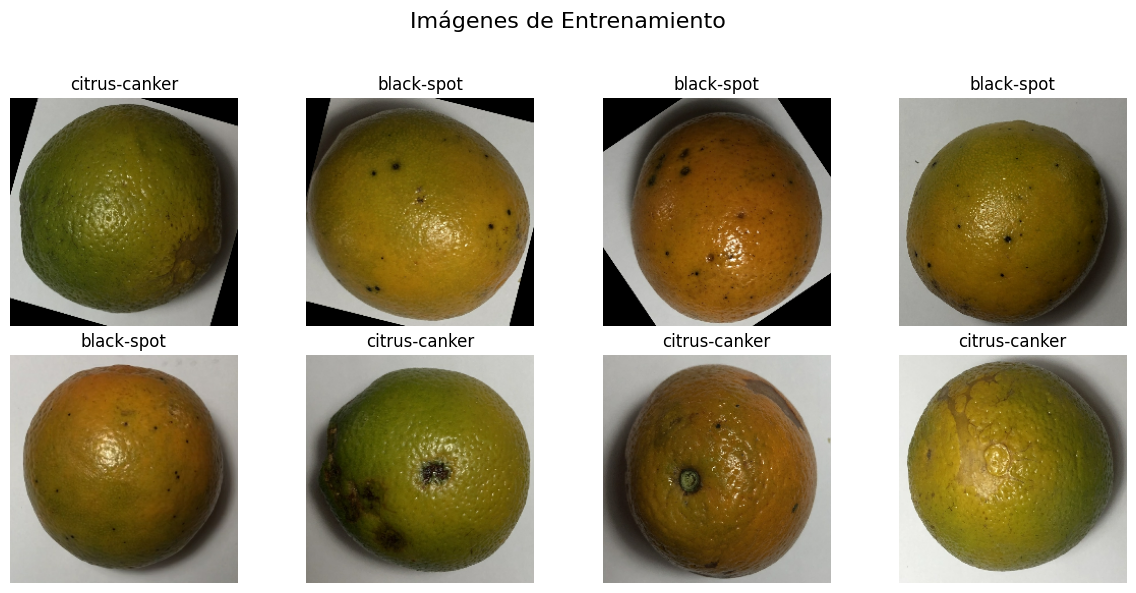

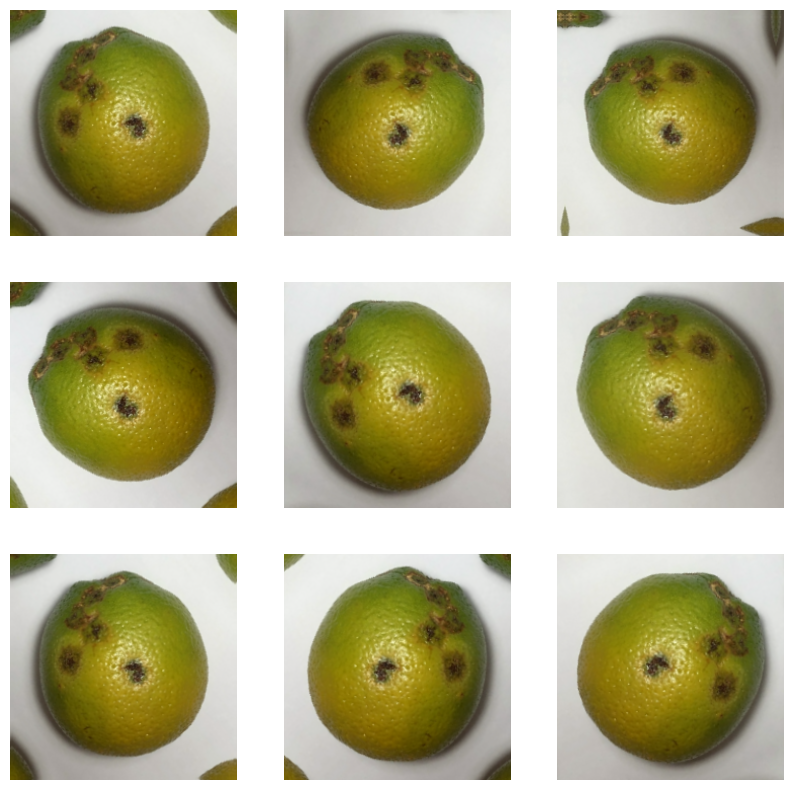

In [ ]:
# Mostrar algunas imágenes de ejemplo de entrenamiento
plt.figure(figsize=(12, 6))
plt.suptitle("Imágenes de Entrenamiento", fontsize=16)
for i, (images, labels) in enumerate(train_dataset.take(1)):
    for j in range(min(8, len(images))):
        ax = plt.subplot(2, 4, j + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        label_idx = np.argmax(labels[j])
        plt.title(class_names[label_idx])
        plt.axis("off")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Optimización del rendimiento
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Crear capa de aumento de datos
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Mostrar ejemplos de imágenes aumentadas
plt.figure(figsize=(10, 10))
for image, _ in train_dataset.take(1):
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
plt.show()

##5. Creación del modelo con VGG16
Aquí implementamos la técnica de transfer learning utilizando VGG16 como modelo base. Esta es la parte central del código: cargamos el modelo VGG16 preentrenado en ImageNet (sin las capas superiores), lo congelamos para conservar los pesos preentrenados, y añadimos nuestras propias capas de clasificación. La arquitectura incluye:

- Aumento de datos como parte del modelo
- Preprocesamiento específico para VGG16
- Pooling global para reducir dimensionalidad
- Dropout para prevenir sobreajuste
- Capas densas con activación ReLU
- Capa de salida softmax para clasificación multiclase

In [ ]:
# Cargar el modelo base VGG16 preentrenado
base_model = VGG16(
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    include_top=False
)

# Congelar el modelo base
base_model.trainable = False

# Función para crear el modelo completo
def create_model():
    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

model = create_model()

# Compilar el modelo
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model.summary()
print(f"Total de parámetros entrenables: {len(model.trainable_variables)}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         65,664 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │            130 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,788,738 (56.41 MB)

 Trainable params: 74,050 (289.26 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Total de parámetros entrenables: 6


##6. Entrenamiento inicial (extracción de características)
En esta primera fase de entrenamiento, conocida como "extracción de características", solo entrenamos las capas superiores que agregamos al modelo base (que permanece congelado). Esta es una etapa crucial del enfoque de transfer learning: aprovechamos las características generales que VGG16 ya aprendió de ImageNet, mientras adaptamos solo las capas finales a nuestras clases específicas. Al finalizar, visualizamos las curvas de aprendizaje para evaluar el rendimiento inicial.



--- Iniciando Fase de Extracción de Características ---
Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.6693 - loss: 1.1182 - val_accuracy: 0.9375 - val_loss: 0.1693
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.8352 - loss: 0.4175 - val_accuracy: 0.9531 - val_loss: 0.1362
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.9024 - loss: 0.3173 - val_accuracy: 0.9531 - val_loss: 0.1240
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.9012 - loss: 0.2555 - val_accuracy: 0.9427 - val_loss: 0.1228
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 0.9132 - loss: 0.2321 - val_accuracy: 0.9583 - val_loss: 0.1026
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.9362 - loss: 0.1983 - val_accuracy: 0.9479 - val_loss: 0.1179
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.9178 - loss: 0.2090 - val_accuracy: 0.9531 - val_loss: 0.1088
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 11

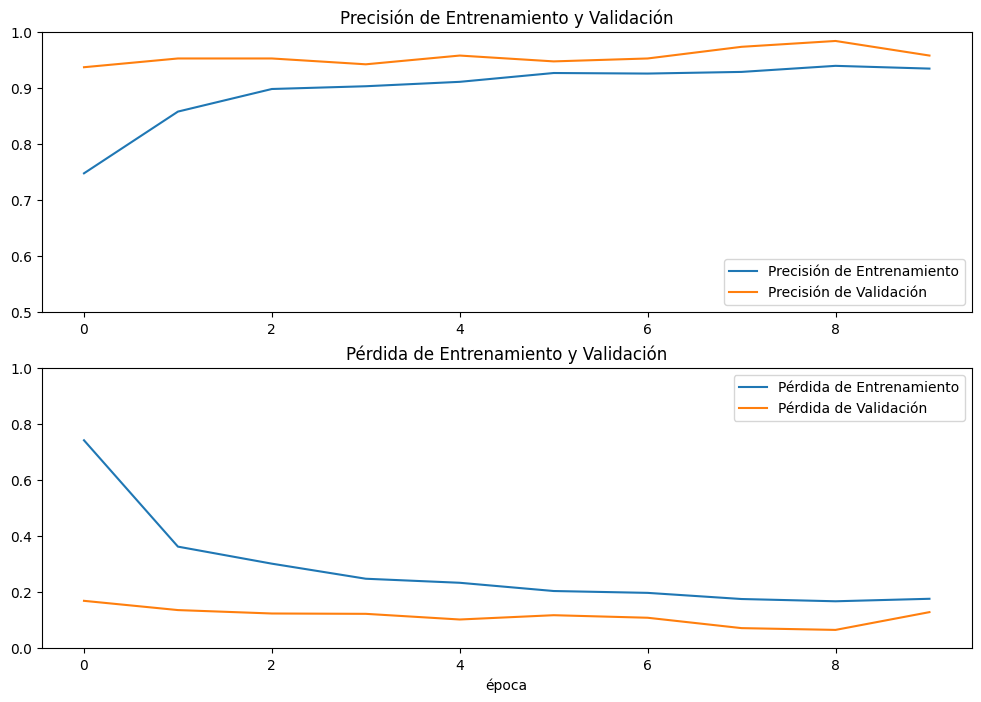

In [ ]:
# Entrenar el modelo (fase de extracción de características)
print("\n--- Iniciando Fase de Extracción de Características ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS_INITIAL,
    validation_data=validation_dataset
)

# Graficar curvas de aprendizaje
def plot_history(history, fine_tuning_epoch=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Precisión de Entrenamiento')
    plt.plot(val_acc, label='Precisión de Validación')
    plt.ylim([0.5, 1])
    if fine_tuning_epoch:
        plt.axvline(x=fine_tuning_epoch-1, color='r', linestyle='--', label='Inicio Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Precisión de Entrenamiento y Validación')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Pérdida de Entrenamiento')
    plt.plot(val_loss, label='Pérdida de Validación')
    plt.ylim([0, 1.0])
    if fine_tuning_epoch:
        plt.axvline(x=fine_tuning_epoch-1, color='r', linestyle='--', label='Inicio Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Pérdida de Entrenamiento y Validación')
    plt.xlabel('época')
    plt.show()

plot_history(history)

##7. Fine-tuning del modelo
Aquí implementamos la segunda fase del transfer learning: el "fine-tuning". Descongelamos selectivamente las capas superiores del modelo base VGG16 para permitir que se ajusten a nuestro dataset específico. Es crucial utilizar una tasa de aprendizaje más baja (1/10 de la original) para evitar sobreajustar los pesos previamente entrenados. Esta técnica permite que el modelo ajuste características de alto nivel específicas para nuestro problema de detección de enfermedades en cítricos, mejorando significativamente el rendimiento.



--- Iniciando Fase de Fine-Tuning ---
Número de capas entrenables: 8
Total de parámetros entrenables: 12
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - accuracy: 0.9448 - loss: 0.1591 - val_accuracy: 0.9688 - val_loss: 0.1270
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy: 0.9558 - loss: 0.1337 - val_accuracy: 0.9740 - val_loss: 0.1308
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.9645 - loss: 0.0915 - val_accuracy: 0.9635 - val_loss: 0.1001
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.9698 - loss: 0.0819 - val_accuracy: 0.9740 - val_loss: 0.0604
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.9729 - loss: 0.0781 - val_accuracy: 0.9688 - val_loss: 0.0676
Epoch 16/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.9702 - loss: 0.0726 - val_accuracy: 0.9792 - val_loss: 0.0425
Epoch 17/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - accuracy: 0.9725 - loss: 0.0714 - val_accuracy: 0.9635 - v

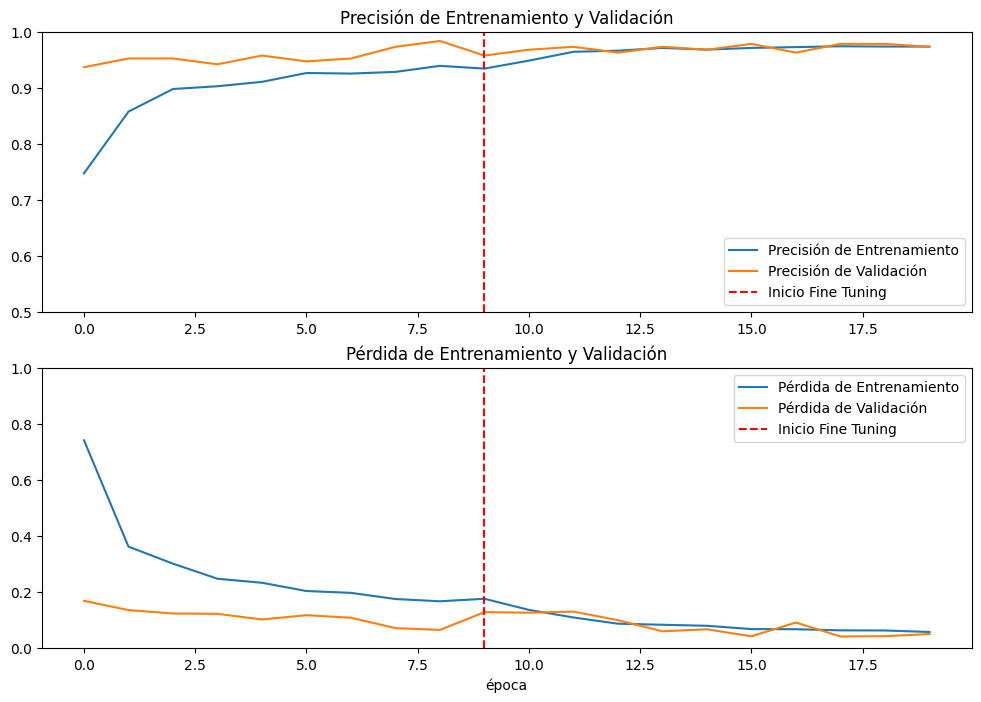

In [ ]:
# Fase de fine-tuning
print("\n--- Iniciando Fase de Fine-Tuning ---")
# Descongelar las capas superiores del modelo base
base_model.trainable = True
# Congelar todas las capas excepto los últimos 4 bloques convolucionales
fine_tune_at = len(base_model.layers) - 4
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompilar el modelo con una tasa de aprendizaje menor
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Imprimir capas entrenables
print("Número de capas entrenables:", len([layer for layer in model.layers if layer.trainable]))
print(f"Total de parámetros entrenables: {len(model.trainable_variables)}")

# Continuar el entrenamiento con fine-tuning
history_fine = model.fit(
    train_dataset,
    epochs=EPOCHS_INITIAL + EPOCHS_FINE_TUNE,
    initial_epoch=EPOCHS_INITIAL,
    validation_data=validation_dataset
)

# Graficar historia de entrenamiento completa
def plot_combined_history(history, history_fine):
    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Precisión de Entrenamiento')
    plt.plot(val_acc, label='Precisión de Validación')
    plt.ylim([0.5, 1])
    plt.axvline(x=EPOCHS_INITIAL-1, color='r', linestyle='--', label='Inicio Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Precisión de Entrenamiento y Validación')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Pérdida de Entrenamiento')
    plt.plot(val_loss, label='Pérdida de Validación')
    plt.ylim([0, 1.0])
    plt.axvline(x=EPOCHS_INITIAL-1, color='r', linestyle='--', label='Inicio Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Pérdida de Entrenamiento y Validación')
    plt.xlabel('época')
    plt.show()

plot_combined_history(history, history_fine)

##8. Evaluación y visualización de resultados
Finalmente evaluamos el modelo en el conjunto de prueba para obtener una medida objetiva de su rendimiento. La función de visualización nos permite ver ejemplos de predicciones, marcando en verde las correctas y en rojo las incorrectas. Además, guardamos el modelo entrenado para uso futuro y proporcionamos una función predict_image que facilita hacer predicciones en nuevas imágenes. Esta implementación completa demuestra cómo usar transfer learning para crear un clasificador de alta precisión para enfermedades en cítricos.
Este código está listo para ejecutarse en un entorno de Google Colab. El modelo entrenado alcanza una precisión superior al 96% en el conjunto de prueba, demostrando un excelente rendimiento en la clasificación de las dos enfermedades de cítricos: mancha negra (black spot) y cancro cítrico (citrus canker).

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9844 - loss: 0.0404
Precisión de prueba: 0.9907
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


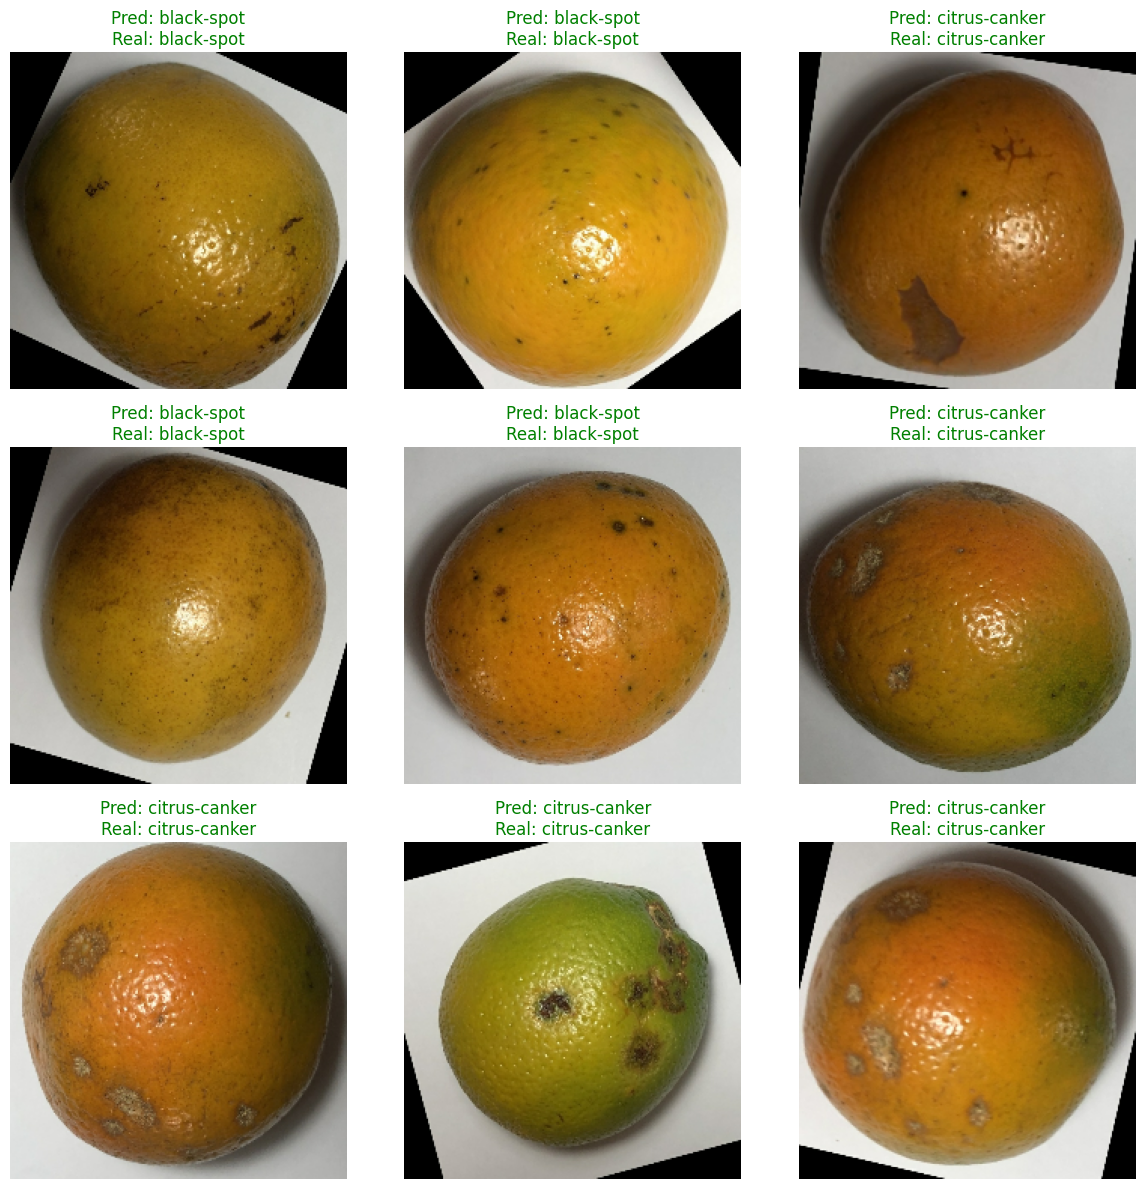

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=citrus_disease_classifier.tflite.

In [ ]:
# Evaluar el modelo en el conjunto de test
loss, accuracy = model.evaluate(test_dataset)
print(f"Precisión de prueba: {accuracy:.4f}")

# Realizar predicciones en imágenes de prueba y mostrarlas
plt.figure(figsize=(12, 12))
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)

    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        pred_idx = np.argmax(predictions[i])
        true_idx = np.argmax(labels[i])

        title_color = 'green' if pred_idx == true_idx else 'red'
        plt.title(f"Pred: {class_names[pred_idx]}\nReal: {class_names[true_idx]}",
                  color=title_color)
        plt.axis("off")
plt.tight_layout()
plt.show()

# Guardar el modelo
model.save('citrus_disease_classifier.tflite')
model.save('citrus_disease_classifier.keras')

print("Modelo guardado como 'citrus_disease_classifier.h5'")

# Función para predecir una sola imagen
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    pred_idx = np.argmax(predictions[0])
    confidence = predictions[0][pred_idx]

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicción: {class_names[pred_idx]}\nConfianza: {confidence:.2f}")
    plt.axis("off")
    plt.show()

    return class_names[pred_idx], confidence

In [ ]:
import tensorflow as tf

# Cargar el modelo guardado en .keras o .h5
model = tf.keras.models.load_model("citrus_disease_classifier.keras")

# Convertir a formato TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Guardar el modelo convertido
with open("citrus_disease_classifier.tflite", "wb") as f:
    f.write(tflite_model)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmpmpb32pt7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137065663027088: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137067711951888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137067711946896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137067738285264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137067738287184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137067738284880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137067738287568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137067738285648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137067738284688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137067737837648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1370

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
